<a href="https://colab.research.google.com/github/LudwigMeder/Time-Series-Prediction-of-the-NAO/blob/tanja_dev/development/NAO_NBeats_first_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#!pip install nbeats_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

In [2]:
NAO_df = pd.read_csv("norm.daily.nao.cdas.z500.19500101_current.csv")

In [3]:
print(NAO_df)

       year  month  day  nao_index_cdas
0      1950      1    1        0.365000
1      1950      1    2        0.096000
2      1950      1    3       -0.416000
3      1950      1    4       -0.616000
4      1950      1    5       -0.261000
...     ...    ...  ...             ...
27159  2024      5   11        0.688005
27160  2024      5   12        0.517683
27161  2024      5   13        0.520576
27162  2024      5   14        0.357431
27163  2024      5   15       -0.142666

[27164 rows x 4 columns]


In [4]:
# convert to datetime format and set as index
NAO_df['date'] = pd.to_datetime(NAO_df[['year', 'month', 'day']])
# Drop the individual year, month, day columns if needed
NAO_df.drop(columns=['year', 'month', 'day'], inplace=True)
NAO_df.set_index('date', inplace=True)

print(NAO_df)

            nao_index_cdas
date                      
1950-01-01        0.365000
1950-01-02        0.096000
1950-01-03       -0.416000
1950-01-04       -0.616000
1950-01-05       -0.261000
...                    ...
2024-05-11        0.688005
2024-05-12        0.517683
2024-05-13        0.520576
2024-05-14        0.357431
2024-05-15       -0.142666

[27164 rows x 1 columns]


In [5]:
# calculate monthly mean and adding to the datafram
# Calculate monthly mean
monthly_mean = NAO_df.resample('M').mean()

# Broadcast monthly mean to each day within the same month
monthly_mean_broadcasted = monthly_mean.reindex(NAO_df.index, method='bfill')

# Merge the broadcasted monthly mean back to the original DataFrame
NAO_df['monthly_mean'] = monthly_mean_broadcasted
print(NAO_df)

            nao_index_cdas  monthly_mean
date                                    
1950-01-01        0.365000      0.463516
1950-01-02        0.096000      0.463516
1950-01-03       -0.416000      0.463516
1950-01-04       -0.616000      0.463516
1950-01-05       -0.261000      0.463516
...                    ...           ...
2024-05-11        0.688005      0.036660
2024-05-12        0.517683      0.036660
2024-05-13        0.520576      0.036660
2024-05-14        0.357431      0.036660
2024-05-15       -0.142666      0.036660

[27164 rows x 2 columns]


In [10]:
Monthly_NAO_df = NAO_df.groupby([NAO_df.index.year, NAO_df.index.month]).first()
print(Monthly_NAO_df)

           nao_index_cdas  monthly_mean
date date                              
1950 1           0.365000      0.463516
     2           0.993000      0.420714
     3           0.357000      0.008387
     4           1.044000      0.239433
     5           0.071000     -0.261226
...                   ...           ...
2024 1           0.029643      0.064937
     2           1.518900      0.718990
     3           0.871421     -0.066455
     4          -1.730706     -0.411049
     5          -0.704843      0.036660

[893 rows x 2 columns]


In [11]:
Monthly_NAO_df.drop(columns=['nao_index_cdas'], inplace=True)
print(Monthly_NAO_df)

           monthly_mean
date date              
1950 1         0.463516
     2         0.420714
     3         0.008387
     4         0.239433
     5        -0.261226
...                 ...
2024 1         0.064937
     2         0.718990
     3        -0.066455
     4        -0.411049
     5         0.036660

[893 rows x 1 columns]


In [14]:
Monthly_NAO_df.index = Monthly_NAO_df.index.rename(['year', 'month'])

print(Monthly_NAO_df.index.names)

['year', 'month']


In [15]:
# Reset index to turn index (year, month) into regular columns
Monthly_NAO_df_reset = Monthly_NAO_df.reset_index()

# Create 'date' column by combining 'year' and 'month' columns
Monthly_NAO_df_reset['date'] = pd.to_datetime(Monthly_NAO_df_reset[['year', 'month']].assign(day=1))

# Set 'date' column as index
Monthly_NAO_df_reset.set_index('date', inplace=True)

# Drop 'year' and 'month' columns if needed
Monthly_NAO_df_reset.drop(['year', 'month'], axis=1, inplace=True)

# Now, you have 'date' as the index
print(Monthly_NAO_df_reset.head())

            monthly_mean
date                    
1950-01-01      0.463516
1950-02-01      0.420714
1950-03-01      0.008387
1950-04-01      0.239433
1950-05-01     -0.261226


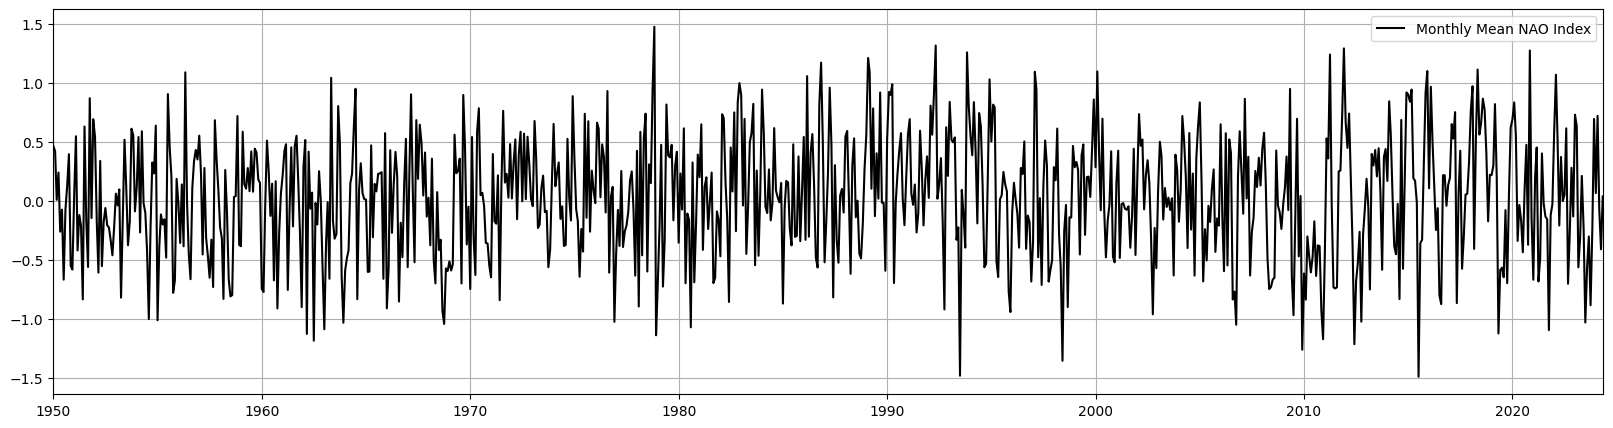

In [16]:
#simple visulization of the time series
plt.figure(figsize=[20,5])
plt.plot(Monthly_NAO_df_reset["monthly_mean"],label="Monthly Mean NAO Index",color="k")
plt.xlim(-7305,19855)
plt.legend()
plt.grid()

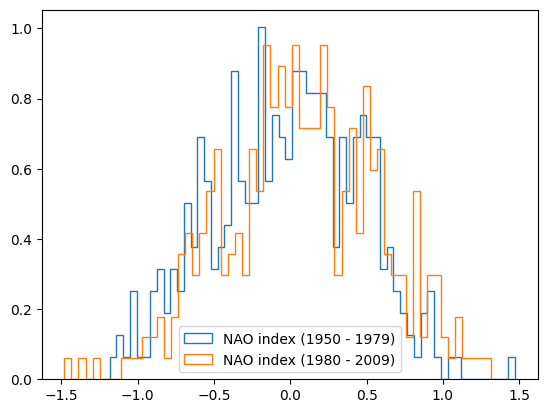

In [17]:
plt.hist(Monthly_NAO_df_reset["monthly_mean"]["1950":"1979"],bins=60,histtype="step",density=True,label="NAO index (1950 - 1979)")
plt.hist(Monthly_NAO_df_reset["monthly_mean"]["1980":"2009"],bins=60,histtype="step",density=True,label="NAO index (1980 - 2009)")
#plt.hist(NAO_df["nao_index_cdas"]["2010":],bins=60,histtype="step",density=True,label="NAO index (2010 - 2024(May))")
plt.legend()
plt.show()

Ab hier erste NBeats prediction versuche

In [18]:
#Splitting Data for training and test data using 80/20 method

Monthly_NAO_df_reset

split_point = int(len(Monthly_NAO_df_reset) * 0.8)

# Split the data into training and test sets
train_df = Monthly_NAO_df_reset.iloc[:split_point]
test_df = Monthly_NAO_df_reset.iloc[split_point:]
print("Train data length:", len(train_df))
print("Test data length:", len(test_df))

Train data length: 714
Test data length: 179


In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
print(train_df[train_df['monthly_mean'] > 1])

            monthly_mean
date                    
1956-05-01      1.088065
1963-05-01      1.041419
1978-11-01      1.473500
1986-03-01      1.055355
1986-11-01      1.170167
1989-02-01      1.209357
1989-03-01      1.090355
1992-05-01      1.314419
1993-11-01      1.256633
1994-12-01      1.028387
1997-02-01      1.092143
2000-02-01      1.095483


In [21]:
# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train_df['monthly_mean'].values.reshape(-1, 1)).reshape(-1)
test_scaled = scaler.transform(test_df['monthly_mean'].values.reshape(-1, 1)).reshape(-1)

In [22]:
# Define a function to create sequences
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data)-input_length):
        x = data[i:(i+input_length)]
        y = data[i+1:(i+1+input_length)]
        xs.append(x)
        ys.append(y[-1])
    return np.array(xs), np.array(ys)

input_length = 12  # For example, using the past 12 months to predict the next month
X_train, y_train = create_sequences(train_scaled, input_length)
X_test, y_test = create_sequences(test_scaled, input_length)

# Reshape for model input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [23]:
import torch
from torch import nn
from nbeats_pytorch.model import NBeatsNet

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have defined the model architecture as per NBeatsNet requirements:
model = NBeatsNet(stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                        forecast_length=1,
                        backcast_length=input_length,
                        hidden_layer_units=64,
                        nb_blocks_per_stack=3,
                        device=device)

model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=12, forecast_length=1, share_thetas=False) at @135858792360560
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=12, forecast_length=1, share_thetas=False) at @135858792360752
     | -- GenericBlock(units=64, thetas_dim=4, backcast_length=12, forecast_length=1, share_thetas=False) at @135858792360848
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=12, forecast_length=1, share_thetas=False) at @135858792365168
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=12, forecast_length=1, share_thetas=False) at @135858792358112
     | -- GenericBlock(units=64, thetas_dim=8, backcast_length=12, forecast_length=1, share_thetas=False) at @135858792360224


In [25]:
# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).float().unsqueeze(-1).to(device)
X_test_tensor = torch.tensor(X_test).float().to(device)
y_test_tensor = torch.tensor(y_test).float().unsqueeze(-1).to(device)

In [26]:
#Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Unpack the model's output to separately get backcast and forecast; only use forecast for loss
    _, forecast = model(X_train_tensor)

    # Now, 'forecast' directly refers to the second tensor from the model's
    loss = criterion(forecast, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.1195523589849472
Epoch 10, Loss: 0.11018994450569153
Epoch 20, Loss: 0.1065729558467865
Epoch 30, Loss: 0.1024550050497055
Epoch 40, Loss: 0.09603118151426315
Epoch 50, Loss: 0.08311546593904495
Epoch 60, Loss: 0.06634019315242767
Epoch 70, Loss: 0.050643425434827805
Epoch 80, Loss: 0.03791602700948715
Epoch 90, Loss: 0.028088849037885666
Epoch 100, Loss: 0.019529221579432487
Epoch 110, Loss: 0.011682199314236641
Epoch 120, Loss: 0.01110792439430952
Epoch 130, Loss: 0.0064927032217383385
Epoch 140, Loss: 0.00396763114258647
Epoch 150, Loss: 0.004154984373599291
Epoch 160, Loss: 0.0033784068655222654
Epoch 170, Loss: 0.00266711856238544
Epoch 180, Loss: 0.0018389314645901322
Epoch 190, Loss: 0.0013425163924694061


In [27]:
# Switch model to evaluation mode
model.eval()

# No need to track gradients for prediction
with torch.no_grad():
    # Assuming your model outputs a tuple and we take the second element for prediction
    _, predictions = model(X_test_tensor)

In [28]:
# Ensure predictions are detached from the grad graph and moved to CPU for conversion to numpy
predictions_np = predictions.cpu().detach().numpy()

# Rescale the predictions back to the original scale
# Note: Ensure 'scaler' is the MinMaxScaler instance you used for scaling your data
predictions_rescaled = scaler.inverse_transform(predictions_np)

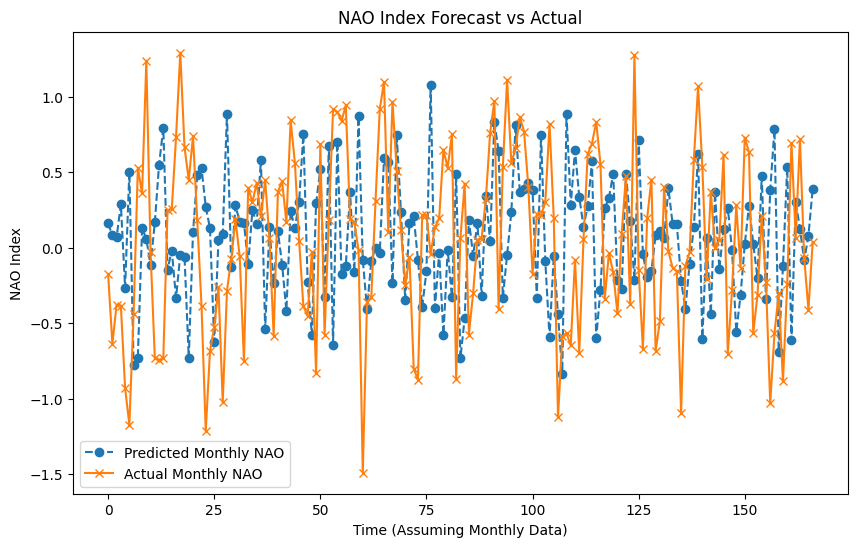

In [29]:
# You might need to adjust how you extract actual test values, particularly if they've been transformed
# Assuming y_test was your actual values tensor for the test set
y_test_np = y_test_tensor.cpu().detach().numpy()

# If the actual test data was also scaled, inversely transform these values too
y_test_rescaled = scaler.inverse_transform(y_test_np)

# Now, plotting
plt.figure(figsize=(10, 6))
plt.plot(predictions_rescaled, label='Predicted Monthly NAO', linestyle='--', marker='o')
plt.plot(y_test_rescaled, label='Actual Monthly NAO', marker='x')
plt.title('NAO Index Forecast vs Actual')
plt.xlabel('Time (Assuming Monthly Data)')
plt.ylabel('NAO Index')
plt.legend()
plt.show()

In [56]:
n_future_steps = 30  # Number of future steps you want to predict
future_predictions = []

# Start with the most recent known data sequence
current_sequence = X_test[-1:].reshape((1, X_test.shape[1], 1))  # Reshaping may vary based on your data

for step in range(n_future_steps):
    # Predict the next step
    with torch.no_grad():
        _, future_step_prediction = model(torch.tensor(current_sequence).float().to(device))
        future_predictions.append(future_step_prediction.cpu().numpy())

    # Update the current_sequence to include the new prediction
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[:, -1, :] = future_step_prediction.cpu().numpy()  # Update the last piece with the new prediction

# If data was normalized, inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Reshape appropriately for scaler.inverse_transform
future_predictions_rescaled = scaler.inverse_transform(future_predictions).flatten()

# future_predictions_rescaled now contains your future predictions in their original scale

In [57]:
import pandas as pd

# Assume NAO_df has a DateTimeIndex
last_date = Monthly_NAO_df_reset.index[-1]  # Gets the last date from your historical data

# Generating future dates starting from the next month of the last_date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_predictions_rescaled), freq='M')

# Creating a DataFrame for the future predictions
future_df = pd.DataFrame(future_predictions_rescaled, index=future_dates, columns=['Predicted_NAO_Index'])

# Concatenate the historical and future prediction DataFrames
full_df = pd.concat([Monthly_NAO_df_reset, future_df])

In [58]:
# Extracting last year's data from the historical DataFrame
last_year_data = Monthly_NAO_df_reset.last('60M')  # Adjust the '12M' if your data's frequency isn't monthly or to change the duration


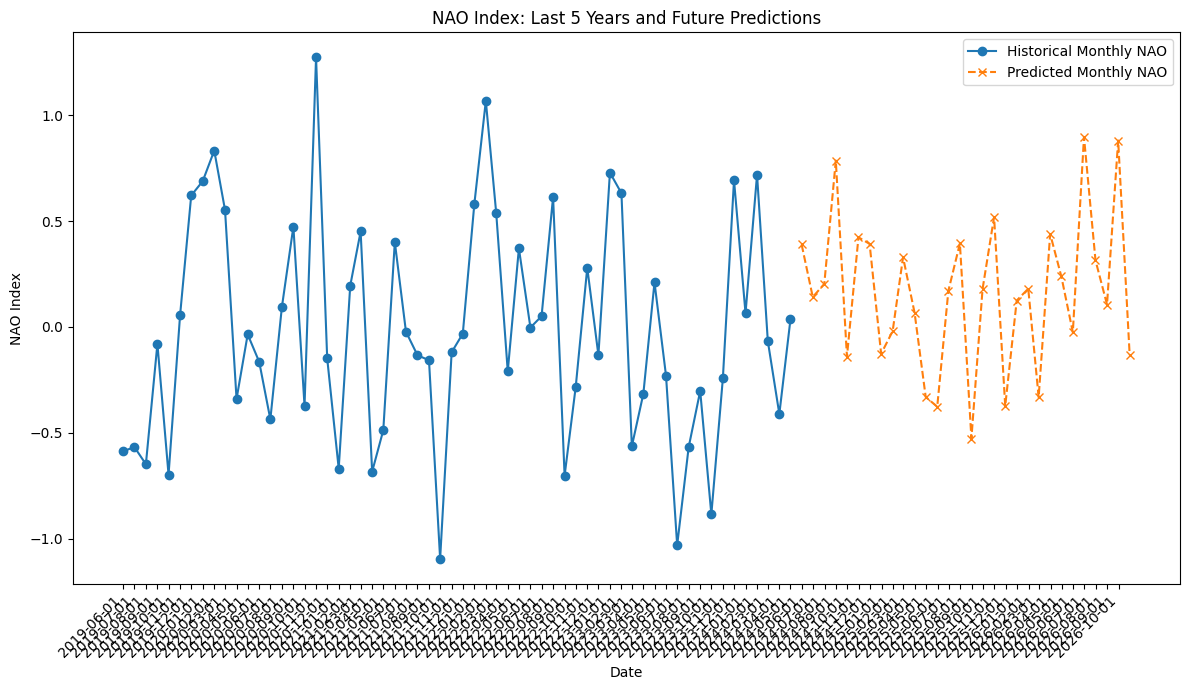

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# Plotting the last year's historical data
plt.plot(last_year_data.index, last_year_data['monthly_mean'], label='Historical Monthly NAO', marker='o')

# Plotting the future predictions
plt.plot(future_df.index, future_df['Predicted_NAO_Index'], linestyle='--', label='Predicted Monthly NAO', marker='x')

plt.title('NAO Index: Last 5 Years and Future Predictions')
plt.xlabel('Date')
plt.ylabel('NAO Index')
plt.legend()

plt.xticks(pd.date_range(last_year_data.index[0], future_df.index[-1], freq='MS'), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [50]:
n_future_steps = 600  # Number of future steps you want to predict
future_predictions = []

# Start with the most recent known data sequence
current_sequence = X_test[-1:].reshape((1, X_test.shape[1], 1))  # Reshaping may vary based on your data

for step in range(n_future_steps):
    # Predict the next step
    with torch.no_grad():
        _, future_step_prediction = model(torch.tensor(current_sequence).float().to(device))
        future_predictions.append(future_step_prediction.cpu().numpy())

    # Update the current_sequence to include the new prediction
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[:, -1, :] = future_step_prediction.cpu().numpy()  # Update the last piece with the new prediction

# If data was normalized, inverse transform the predictions
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Reshape appropriately for scaler.inverse_transform
future_predictions_rescaled = scaler.inverse_transform(future_predictions).flatten()

# future_predictions_rescaled now contains your future predictions in their original scale

In [51]:
# Assume NAO_df has a DateTimeIndex
last_date = Monthly_NAO_df_reset.index[-1]  # Gets the last date from your historical data

# Generating future dates starting from the next month of the last_date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(future_predictions_rescaled), freq='M')

# Creating a DataFrame for the future predictions
future_df = pd.DataFrame(future_predictions_rescaled, index=future_dates, columns=['Predicted_NAO_Index'])

# Concatenate the historical and future prediction DataFrames
full_df = pd.concat([Monthly_NAO_df_reset, future_df])

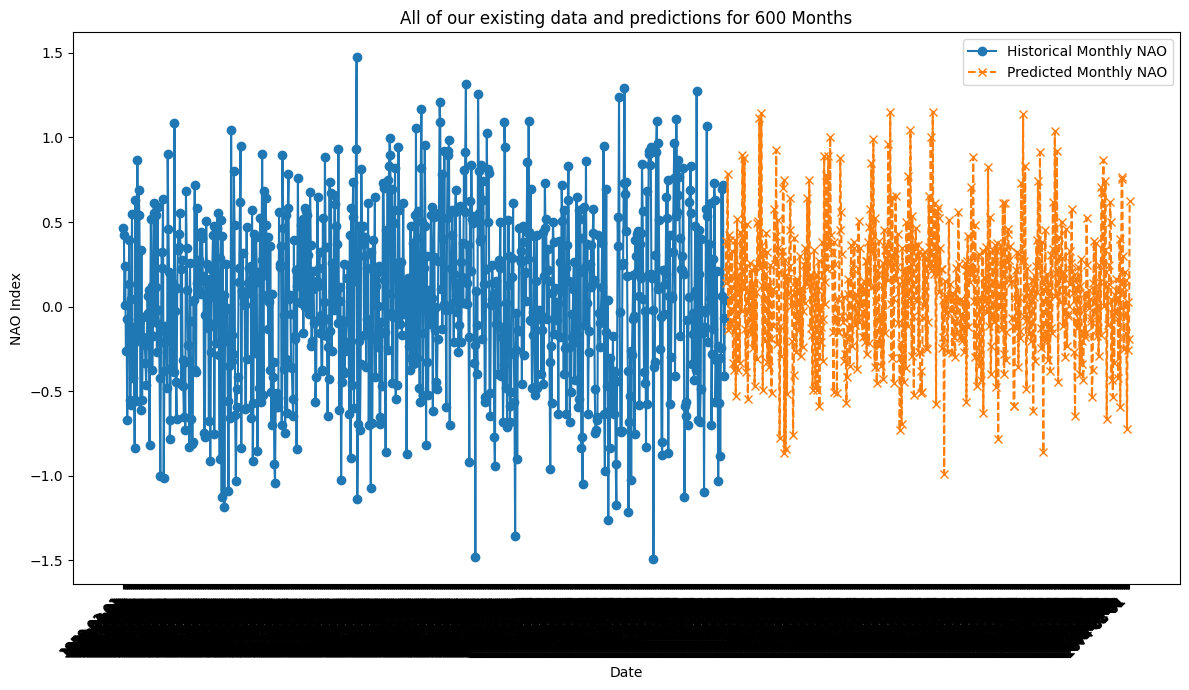

In [54]:
plt.figure(figsize=(12, 7))

# Plotting the last year's historical data
plt.plot(Monthly_NAO_df_reset.index, Monthly_NAO_df_reset['monthly_mean'], label='Historical Monthly NAO', marker='o')

# Plotting the future predictions
plt.plot(future_df.index, future_df['Predicted_NAO_Index'], linestyle='--', label='Predicted Monthly NAO', marker='x')

plt.title('All of our existing data and predictions for 600 Months')
plt.xlabel('Date')
plt.ylabel('NAO Index')
plt.legend()

plt.xticks(pd.date_range(Monthly_NAO_df_reset.index[0], future_df.index[-1], freq='MS'), rotation=45, ha='right')

plt.tight_layout()
plt.show()